# Kaggle Titanic Competition

In this project, I will be creating a machine learning workflow for competing in the [Kaggle Titanic Competition](https://www.kaggle.com/c/titanic).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Read and explore the data:

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preprocessing the Data

In order to preprocess the data, I created the functions found in `functions.py`. I will load them into this notebook.

These functions are able to handle missing values, convert the `age`, `fare`, and `cabin` columns to categorical, extract a title from the `name` column, and create dummy columns for any single column.

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

I will create a function named `preprocess()` that will apply all the functions above to a dataframe in order to process it for machine learning. I will then use this function on the `train` and `holdout` dataframes.

In [4]:
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cols_to_dummy = ['Age_categories', 'Fare_categories',
                     'Title', 'Cabin_type', 'Sex']
    for col in cols_to_dummy:
        df = create_dummies(df, col)
        
    return df

In [5]:
train = preprocess(train)
holdout = preprocess(holdout)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


## Exploring the Data

I would like to look at the `SibSp` column (# of siblings / spouses aboard) and the `Parch` column (# of parents / children aboard) in more detail. I think I could be able to engineer an additional feature from these columns.

In [6]:
explore_cols = ['SibSp', 'Parch', 'Survived']
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


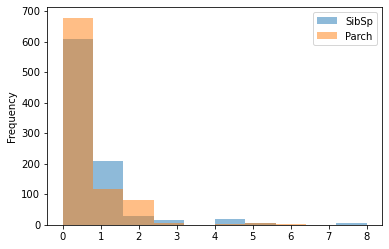

In [7]:
explore[['SibSp', 'Parch']].plot.hist(alpha=0.5)
plt.show()

In [8]:
print(len(explore[explore['SibSp'] == 0]) / len(explore))
print(len(explore[explore['Parch'] == 0]) / len(explore))

0.6823793490460157
0.7609427609427609


Both of these distributions are skewed to the right. About 68% of passengers in the training dataset had no siblings or spouses, and about 76% had no parents or children.

I will create pivot tables to examine how `SibSp` and `Parch` are related to survival.

       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000


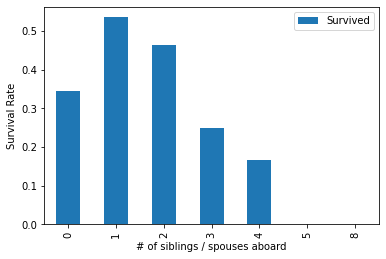

In [9]:
sib_sp_pivot = explore.pivot_table(values='Survived', index='SibSp')
print(sib_sp_pivot)
sib_sp_pivot.plot.bar()
plt.xlabel('# of siblings / spouses aboard')
plt.ylabel('Survival Rate')
plt.legend()
plt.show()

       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000


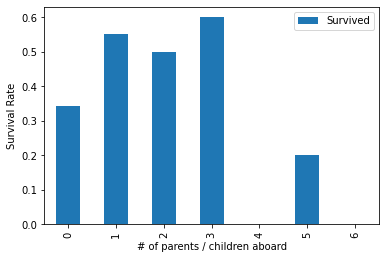

In [10]:
parch_pivot = explore.pivot_table(values='Survived', index='Parch')
print(parch_pivot)
parch_pivot.plot.bar()
plt.xlabel('# of parents / children aboard')
plt.ylabel('Survival Rate')
plt.show()

Each of these features has a similar relationship with survival - in the case of `SibSp`, people with 1 or 2 siblings or spouses had a significantly higher rate of survival than those without a sibling or spouse. For `Parch`, people with 1, 2, or 3 parents or children had a significantly higher rate of survival than those without a parent or child.

I will try combining the two columns into a new column named `family_members`. This column will be the sum of `SibSp` and `Parch`, and will reflect the total number of the passenger's family members that were also aboard the Titanic.

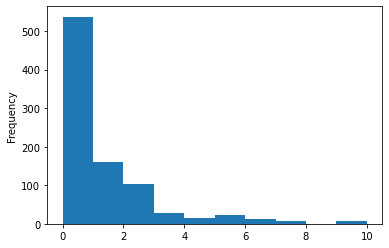

In [11]:
explore['family_members'] = explore['SibSp'] + explore['Parch']
explore['family_members'].plot.hist()
plt.show()

                Survived
family_members          
0               0.303538
1               0.552795
2               0.578431
3               0.724138
4               0.200000
5               0.136364
6               0.333333
7               0.000000
10              0.000000


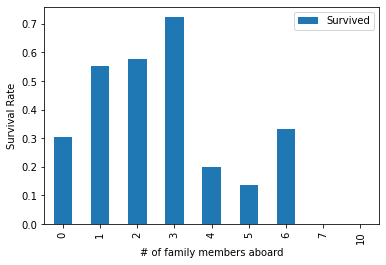

In [12]:
family_pivot = explore.pivot_table(values='Survived', index='family_members')
print(family_pivot)
family_pivot.plot.bar()
plt.xlabel('# of family members aboard')
plt.ylabel('Survival Rate')
plt.show()

In [13]:
print(len(explore[explore['family_members'] == 0]) / len(explore))
print(len(explore[explore['family_members'] >= 4]) / len(explore))

0.6026936026936027
0.06958473625140292


60% of the people in the training data set had no family members aboard. These people who were travelling alone had a significantly lower survival rate than the people who had 1, 2, or 3 family members aboard. At 4 or more family members the survival rate decreases again, but only about 7% of travelers had 4 or more family members aboard, so this could be because of a small sample size.

It looks like traveling alone could be a good indicator of survival.

## Engineering New Features

Above I found that people travelling with no family members were more likely to not survive. I will create a new column named `is_alone` that will have a value of 0 if the passenger has one or more family members aboard, and a value of 1 if the passenger has no family members aboard.

I will write a function to create this column, then try it on my `explore` dataframe.

In [14]:
def process_is_alone(df):
    df['family_size'] = df['SibSp'] + df['Parch']
    df['is_alone'] = 0
    df.loc[(df['family_size'] == 0),'is_alone'] = 1
    df = df.drop(columns=['family_size'])
    return df

          Survived
is_alone          
0         0.505650
1         0.303538


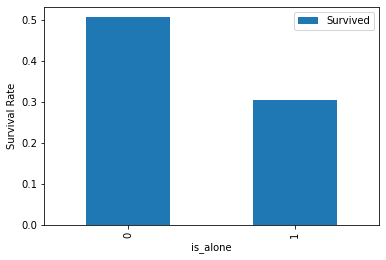

In [15]:
explore = process_is_alone(explore)

alone_pivot = explore.pivot_table(values='Survived', index='is_alone')
print(alone_pivot)
alone_pivot.plot.bar()
plt.xlabel('is_alone')
plt.ylabel('Survival Rate')
plt.show()

About 30% of people travelling alone survived, while about 50% of those with family members survived. I will now apply this function to my `train` and `holdout` dataframes to create this new feature.

In [16]:
train = process_is_alone(train)
holdout = process_is_alone(holdout)

## Selecting the Best-Performing Features

I want to automate the process of finding the best features. I will write a function that:
- Accepts a dataframe as input
- Performs data preparation for machine learning
- Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

I will use a random forest algorithm because in a previous project I found this algorithm to work well with this dataset.

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes(include='number') # select only numeric types
    df = df.dropna(axis=1) # drop columns with null values
    all_X = df.drop(columns=['PassengerId', 'Survived'])
    all_y = df['Survived']
    
    model = RandomForestClassifier(random_state=1)
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = all_X.columns[selector.support_]
    for col in best_columns:
        print(col)
    
    return best_columns

In [18]:
best_cols = select_features(train)

Pclass
Age
SibSp
Parch
Fare
Age_categories_Missing
Age_categories_Infant
Age_categories_Child
Age_categories_Teenager
Age_categories_Young Adult
Age_categories_Adult
Age_categories_Senior
Fare_categories_0-12
Fare_categories_12-50
Fare_categories_50-100
Fare_categories_100+
Title_Master
Title_Miss
Title_Mr
Title_Mrs
Title_Officer
Cabin_type_A
Cabin_type_B
Cabin_type_C
Cabin_type_D
Cabin_type_E
Cabin_type_Unknown
Sex_female
Sex_male
is_alone


## Selecting and Tuning Different Algorithms

Now that I have found the optimal features for a random forest classifier, I want to find the optimal model and hyperparameters. I will write a function to make this model selection and tuning easier.

I will use a grid search to train 3 different models with different combinations of hyperparameters. The 3 models will be Logistic Regression, K-Nearest Neighbors, and a Random Forest. Each model will be a dictionary containing the name of the model, an estimator object for the model, and a dictionary of hyperparameters to use for the grid search. I will make a list containing the dictionary for each model, which will allow me to loop through the models to automate the entire selection and tuning process.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    
    # split the df into X and y
    all_X = df[features]
    all_y = df['Survived']
    
    # create a list of models
    # each model is a dictionary containing the name, estimator, and a dictionary of hyperparameters
    models = [
        
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters': 
                {
                    'solver': ['newton-cg', 'lbfgs', 'liblinear']
                }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters': 
                {
                    'n_neighbors': range(1,20,2),
                    'weights': ['distance', 'uniform'],
                    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                    'p': [1,2]
                }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(random_state=1),
            'hyperparameters': 
                {
                    'n_estimators': [4, 6, 9],
                    'criterion': ['entropy', 'gini'],
                    'max_depth': [2, 5, 10],
                    'max_features': ['log2', 'sqrt'],
                    'min_samples_leaf': [1, 5, 8],
                    'min_samples_split': [2, 3, 5]
                }
        }
    ]
    
    # iterate over the models and perform a grid search
    for model in models:
        print(model['name'])
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        
        model['best_model'] = grid.best_estimator_
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        
        print('Best Score: {}'.format(model['best_score']))
        print('Best Parameters: {}'.format(model['best_params']))
        print('\n')
        
    return models

In [20]:
result = select_model(train,best_cols)

LogisticRegression


C:\Users\ericn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ericn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Score: 0.8204744069912608
Best Parameters: {'solver': 'lbfgs'}


KNeighborsClassifier
Best Score: 0.7789263420724095
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}


RandomForestClassifier
Best Score: 0.8395505617977527
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}




The best model is a Random Forest Classifier, with an accuracy score of almost 84% on the training data.

## Making a Submission to Kaggle

I will create a function that will allow me to easily make predictions on the holdout data and submit them  to Kaggle. The function will accept a trained model, list of columns, and an optional filename argument. It will use the trained model to make predictions on the holdout data, transform these predictions into a dataframe in the correct structure to submit to Kaggle, then export this dataframe as a csv file.

In [21]:
def save_submission_file(model, cols, filename='submission.csv'):
    predictions = model.predict(holdout[cols])
    submission = pd.DataFrame()
    submission['PassengerId'] = holdout['PassengerId']
    submission['Survived'] = predictions
    submission.to_csv(filename, index=False)

In [22]:
best_model = result[2]['best_model']
save_submission_file(best_model, best_cols)

## Next Steps
- Continue to explore the data and create new features, following the workflow and using the functions I created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up the select_features() function.